# MOGDx 

In [1]:
import pandas as pd
import numpy as np
import os
import sys 

sys.path.insert(0 , './../')
from MAIN.utils import *
from MAIN.train import *
import MAIN.preprocess_functions
from MAIN.GNN_MME import GCN_MME , GSage_MME , GAT_MME

from Modules.PNetTorch.MAIN.reactome import ReactomeNetwork
from Modules.PNetTorch.MAIN.Pnet import MaskedLinear , PNET
from Modules.PNetTorch.MAIN.utils import numpy_array_to_one_hot, get_gpu_memory
from Modules.PNetTorch.MAIN.interpret import interpret , evaluate_interpret_save , visualize_importances

import torch
import torch.nn.functional as F
import dgl
from dgl.dataloading import MultiLayerFullNeighborSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import networkx as nx
from datetime import datetime
import joblib
import warnings
import gc
import copy

warnings.filterwarnings("ignore")

print("Finished Library Import \n")

%load_ext autoreload
%autoreload 2

Finished Library Import 



In [2]:
data_input = './../../data/PPMI/03_final/BL/'
snf_net = 'DNAm_graph.graphml'
gen_net = True
index_col = 'index'
target = 'CONCOHORT_DEFINITION'
interpret_feat = True
pnet = True

In [3]:
datModalities , meta = data_parsing(data_input , ['DNAm' , 'mRNA' , 'CSF' ] , target , index_col)

Using cuda device
Total = 11.5Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb


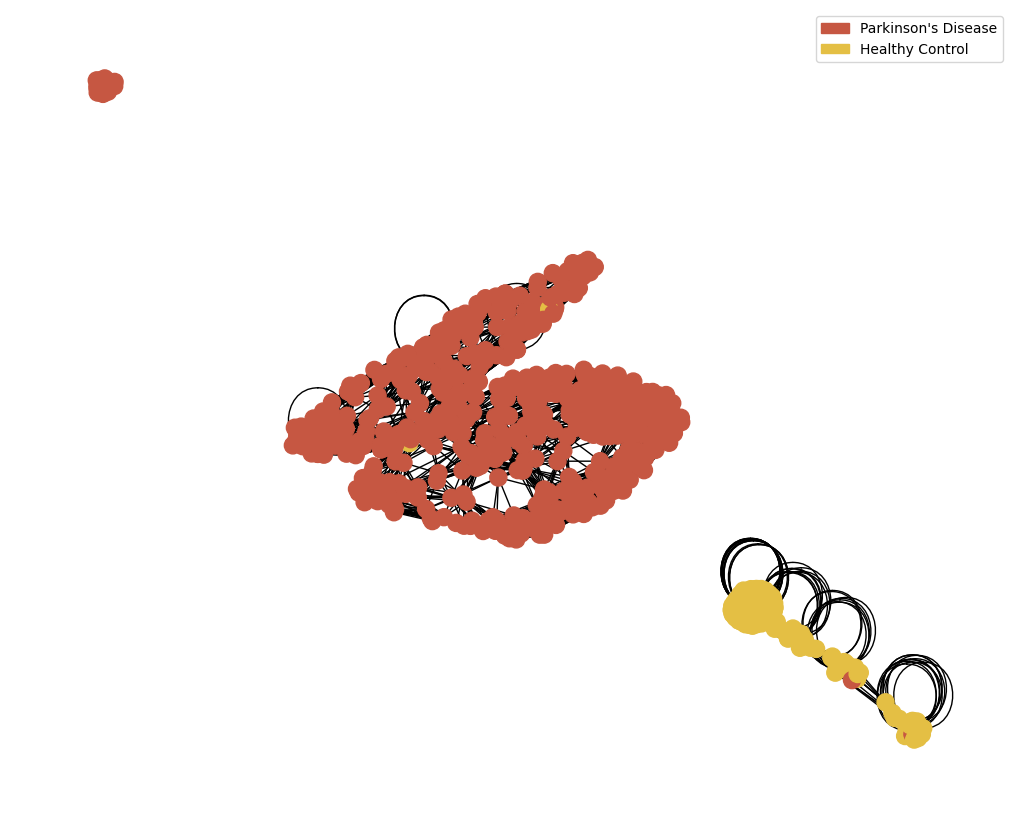

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=300000, out_features=228, bias=True)
        (1): MaskedLinear(in_features=228, out_features=166, bias=True)
        (2): MaskedLinear(in_features=166, out_features=254, bias=True)
        (3): MaskedLinear(in_features=254, out_features=198, bias=True)
        (4): MaskedLinear(in_features=198, out_features=104, bias=True)
        (5): MaskedLinear(in_features=104, out_features=27, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=228, out_features=32, bias=True)
        (1): Linear(in_features=166, out_features=32, bias=True)
        (2): Linear(in_features=254, out_features=32, bias=True)
        (3): Linear(in_features=198, out_features=32, bias=True)
        (4): Linear(in_features=104, out_features=32, bias=True)
        (5): Linear(in_

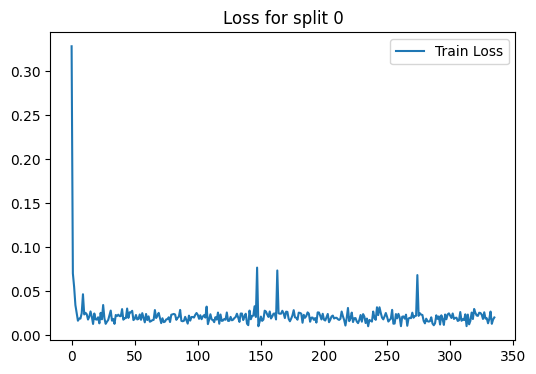

Fold : 1 | Test Accuracy = 0.9874 | F1 = 0.9828 
Total = 11.5Gb 	 Reserved = 4.9Gb 	 Allocated = 1.7Gb
Feature Level Importance
Total = 11.5Gb 	 Reserved = 3.9Gb 	 Allocated = 1.7Gb
Linear(in_features=300000, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=24939, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=4785, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
Masked

<Figure size 640x480 with 0 Axes>

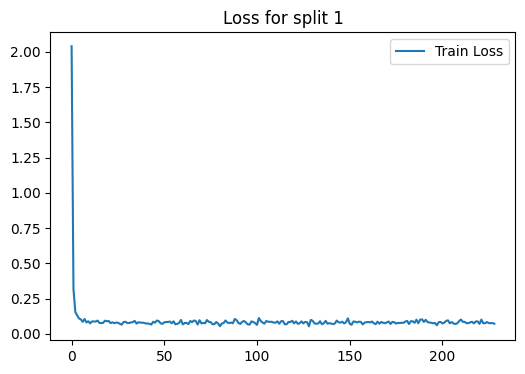

Fold : 2 | Test Accuracy = 1.0000 | F1 = 1.0000 
Total = 11.5Gb 	 Reserved = 5.0Gb 	 Allocated = 1.7Gb
Feature Level Importance
Total = 11.5Gb 	 Reserved = 3.7Gb 	 Allocated = 1.7Gb
Linear(in_features=300000, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=24939, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=4785, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
Masked

<Figure size 640x480 with 0 Axes>

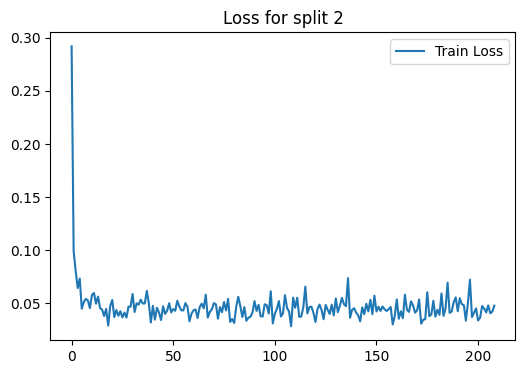

Fold : 3 | Test Accuracy = 1.0000 | F1 = 1.0000 
Total = 11.5Gb 	 Reserved = 4.9Gb 	 Allocated = 1.7Gb
Feature Level Importance
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=24939, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=4785, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)

<Figure size 640x480 with 0 Axes>

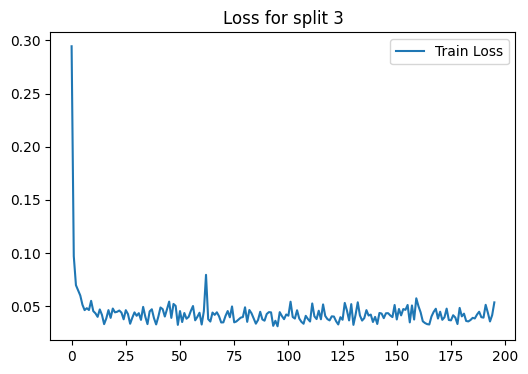

Fold : 4 | Test Accuracy = 0.9937 | F1 = 0.9930 
Total = 11.5Gb 	 Reserved = 4.8Gb 	 Allocated = 1.7Gb
Feature Level Importance
Total = 11.5Gb 	 Reserved = 3.6Gb 	 Allocated = 1.7Gb
Linear(in_features=300000, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=24939, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
MaskedLinear(in_features=166, out_features=254, bias=True)
MaskedLinear(in_features=254, out_features=198, bias=True)
MaskedLinear(in_features=198, out_features=104, bias=True)
MaskedLinear(in_features=104, out_features=27, bias=True)
Linear(in_features=4785, out_features=228, bias=True)
MaskedLinear(in_features=228, out_features=166, bias=True)
Masked

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['DNAm' , 'mRNA' , 'CSF' ] , target , index_col)

if interpret_feat : 
    features = {}
    for i , mod in enumerate(datModalities) : 
        features[i] = list(datModalities[mod].columns)
    model_scores = {}
    layer_importance_scores = {}
        
if pnet : 
    # List of cancer genes was taken from the PNet paper dataset
    genes = pd.read_csv('./../../data/genelists/pd_genelist.txt', header=0 , delimiter='\t')

    # Build network to obtain gene and pathway relationships
    net = ReactomeNetwork(genes_of_interest=np.unique(list(genes['genes'].values)) , n_levels=5)

if gen_net : 
    g, meta = gen_net_from_data(meta , 'BL' , './../../data/PPMI/03_final/ext_data/' , 'sec23' , 'LlamaInst' , False , True , snf=False)
else :
    graph_file = data_input + '../Networks/' + snf_net
    g = nx.read_graphml(graph_file)

meta = meta.loc[list(g.nodes())]
meta = meta.loc[sorted(meta.index)]
label = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64))

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

h = reduce(merge_dfs , list(datModalities.values()))
h = h.loc[meta.index]
h = h.loc[sorted(h.index)]

g = dgl.from_networkx(g , node_attrs=['idx' , 'label'])

g.ndata['feat'] = torch.Tensor(h.to_numpy())
g.ndata['label'] = label
#g = dgl.add_self_loop(g)

del datModalities
gc.collect()

output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GCN_MME(MME_input_shapes , [16 , 32] , 32 , [16]  , len(meta.unique()), PNet=net).to(device)
    
    print(model)
    print(g)
    
    g = g.to(device)

    get_gpu_memory()
    loss_plot = train(g, train_index, device ,  model , label , 2000 , 1e-3 , 100 , batch_size=32)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    sampler = MultiLayerFullNeighborSampler(
        len(model.gnnlayers),  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=8,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-2])
    test_labels.extend(test_output_metrics[-1])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = copy.deepcopy(model).to('cpu')
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = copy.deepcopy(model).to('cpu')
        best_idx   = i

    if interpret_feat : 
        get_gpu_memory()
        torch.cuda.empty_cache()
        gc.collect()
        model.eval()
        model.features = [element for sublist in features.values() for element in sublist]
        if i ==0 :
            model_scores['Input Features'] = {}
            model_scores['Input Features']['mad'] = pd.DataFrame(model.feature_importance(test_dataloader , device).abs().mean(axis=0)).T
        else :
            model_scores['Input Features']['mad'].loc[i]  = model.feature_importance(test_dataloader , device).abs().mean(axis=0)

        get_gpu_memory()
        torch.cuda.empty_cache()
        gc.collect()
        layer_importance_scores[i] = model.layerwise_importance(test_dataloader , device)

        # Get the number of layers of the model
        n_layers = len(next(iter(layer_importance_scores[i].values())))
        
        # Sum corresponding modalities importances
        mean_absolute_distance = [sum([layer_importance_scores[i][k][ii].abs().mean() for k in layer_importance_scores[i].keys()]) for ii in range(n_layers)]
        summed_variation_attr  = [sum([layer_importance_scores[i][k][ii].std()/max(layer_importance_scores[i][k][ii].std()) for k in layer_importance_scores[i].keys()]) for ii in range(n_layers)]
    
        for ii , (mad , sva) in  enumerate(zip(mean_absolute_distance , summed_variation_attr)) :
            layer_title = f"Pathway Level {ii} Importance" if ii > 0 else "Gene Importance"
            if i == 0 : 
                model_scores[layer_title] =  {}
                model_scores[layer_title]['mad'] = pd.DataFrame(mad).T
                model_scores[layer_title]['sva'] = pd.DataFrame(sva).T
            else : 
                model_scores[layer_title]['mad'].loc[i] = mad
                model_scores[layer_title]['sva'].loc[i] = sva

    get_gpu_memory()
    del model , test_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
node_true        = []
display_label = meta.astype('category').cat.categories
for pred , true in zip(all_predictions_conf.argmax(1) , list(test_labels.detach().cpu().argmax(1).numpy()))  : 
    node_predictions.append(display_label[pred])
    node_true.append(display_label[true])

preds = pd.DataFrame({'Actual' : node_true , 'Predicted' : node_predictions})

In [6]:
from Modules.PNetTorch.MAIN.interpret import pnet_significance_testing, pnet_model_significance_testing , calculate_es

In [7]:
sig_feats = pnet_significance_testing(model_scores , key = 'mad')

10902 Feautures have p-value < 0.01 in Layer Input Features:
38 Feautures have p-value < 0.01 in Layer Gene Importance:
6 Feautures have p-value < 0.01 in Layer Pathway Level 1 Importance:
3 Feautures have p-value < 0.01 in Layer Pathway Level 2 Importance:
1 Feautures have p-value < 0.01 in Layer Pathway Level 3 Importance:
0 Feautures have p-value < 0.01 in Layer Pathway Level 4 Importance:
0 Feautures have p-value < 0.01 in Layer Pathway Level 5 Importance:


In [12]:
avg_gene_ranking = pd.merge(model_scores['Gene Importance']['mad'].mean(axis=0).reset_index() , genes , left_on='index' , right_on='genes')

In [13]:
avg_gene_ranking.sort_values(0, ascending=False).iloc[:20]

,index,0,genes,group
155,PARP1,19.974087,PARP1,pos
105,KCNJ4,17.786617,KCNJ4,pos
147,NGF,14.541712,NGF,pos
32,CREB1,13.628740,CREB1,pos
139,NCAPG2,12.912572,NCAPG2,pos
180,RPL6,12.682230,RPL6,pos
162,PLA2G6,12.546354,PLA2G6,pos
53,ENG,11.722697,ENG,neg
134,MRE11,11.211393,MRE11,pos
0,A2M,11.033275,A2M,pos


Enrichment Score for Pos: 0.47235867673275517
The Observed Effect Size (ES) of genes related to outcome is 0.47235867673275517 with significance p-value 0.37362637362637363


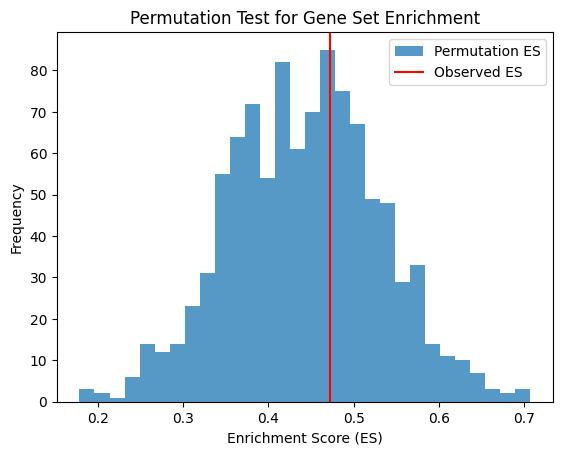

Enrichment Score for Pos: 0.4573541108299704
The Observed Effect Size (ES) of genes related to outcome is 0.4573541108299704 with significance p-value 0.5844155844155844


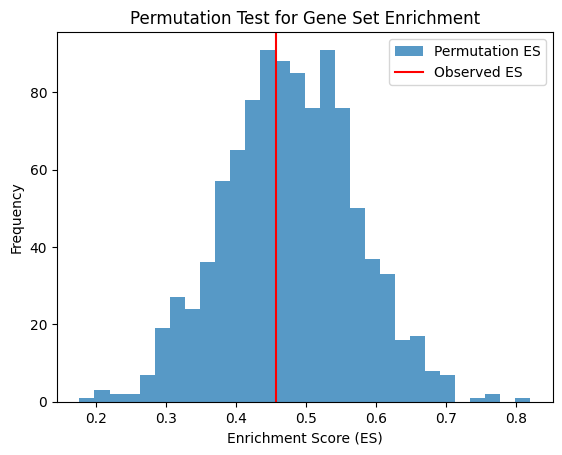

Enrichment Score for Pos: 0.4624963729989295
The Observed Effect Size (ES) of genes related to outcome is 0.4624963729989295 with significance p-value 0.5454545454545454


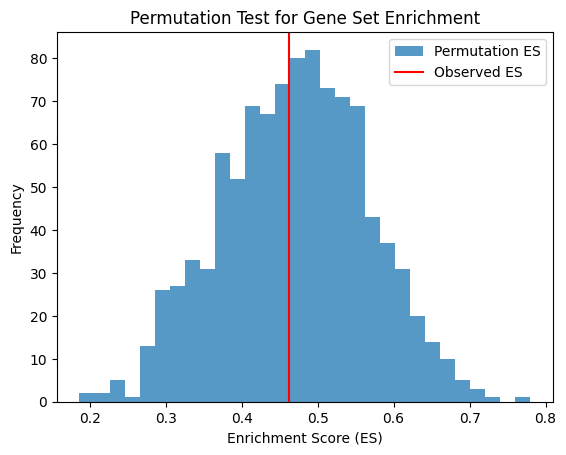

Enrichment Score for Pos: 0.5407442298589968
The Observed Effect Size (ES) of genes related to outcome is 0.5407442298589968 with significance p-value 0.25674325674325676


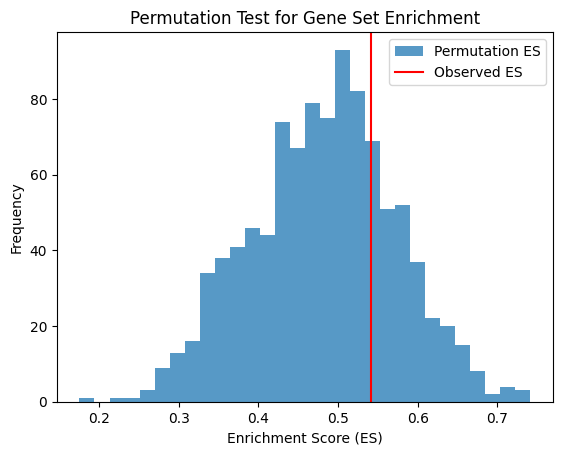

Enrichment Score for Pos: 0.5057006349750593
The Observed Effect Size (ES) of genes related to outcome is 0.5057006349750593 with significance p-value 0.3166833166833167


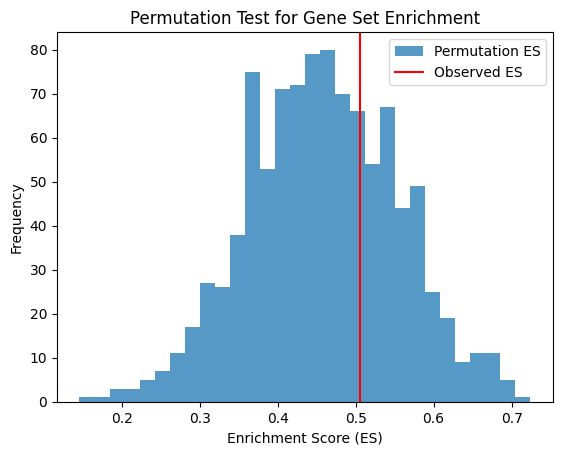

In [14]:
pnet_model_significance_testing(model_scores['Gene Importance']['mad'],genes[genes['group'] == 'pos']['genes'])

Enrichment Score for Pos: 0.41922472271264766
The Observed Effect Size (ES) of genes related to outcome is 0.41922472271264766 with significance p-value 0.04695304695304695


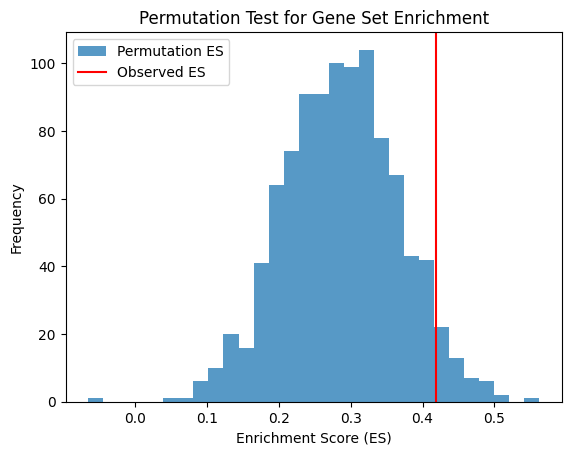

In [15]:
S = np.array(genes[genes['group'] == 'pos']['genes'])
r = model_scores['Gene Importance']['mad'].mean(axis=0).sort_values(ascending=False)

r_index = np.array(r.index)
r = r.to_numpy()
hits = np.isin(r_index , S)

N_R = np.sum(np.abs(r[hits])**1)

real_es_pos = calculate_es(S , r, hits , N_R)
print(f"Enrichment Score for Pos: {real_es_pos}")
perm_es_scores = []

for _ in range(1000):
    hits = np.isin(np.random.permutation(r_index) , S)
    perm_es = calculate_es(S, r, hits , N_R)
    perm_es_scores.append(perm_es)

p_value =  np.sum(perm_es_scores > real_es_pos) / (1000 + 1)

print(f'The Observed Effect Size (ES) of genes related to outcome is {real_es_pos} with significance p-value {p_value}')

# Plotting the permutation ES scores
plt.hist(perm_es_scores, bins=30, alpha=0.75, label='Permutation ES')
plt.axvline(x=real_es_pos, color='red', label='Observed ES')
plt.legend()
plt.title('Permutation Test for Gene Set Enrichment')
plt.xlabel('Enrichment Score (ES)')
plt.ylabel('Frequency')
plt.show()

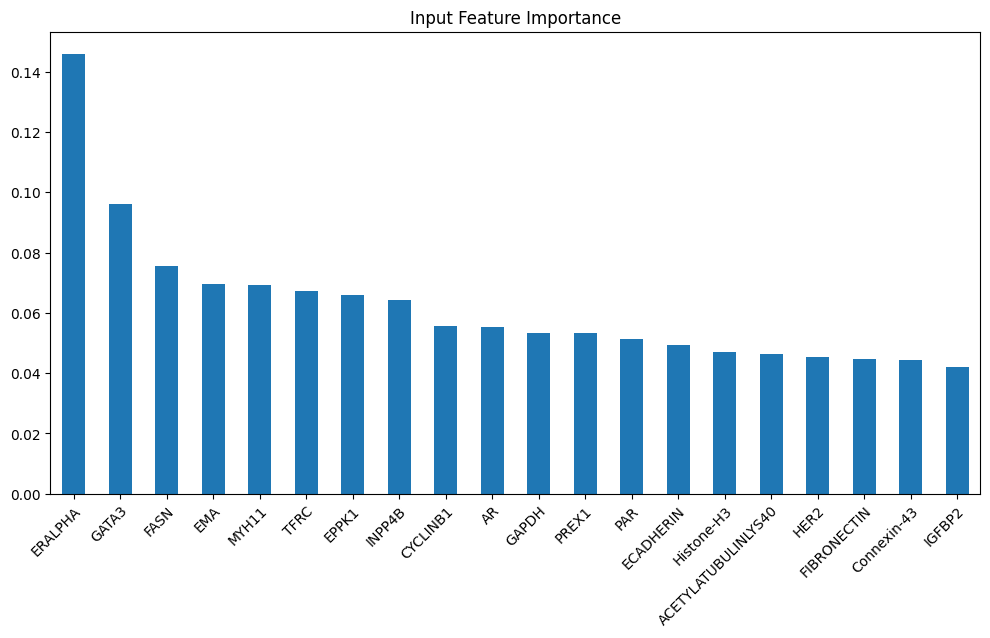

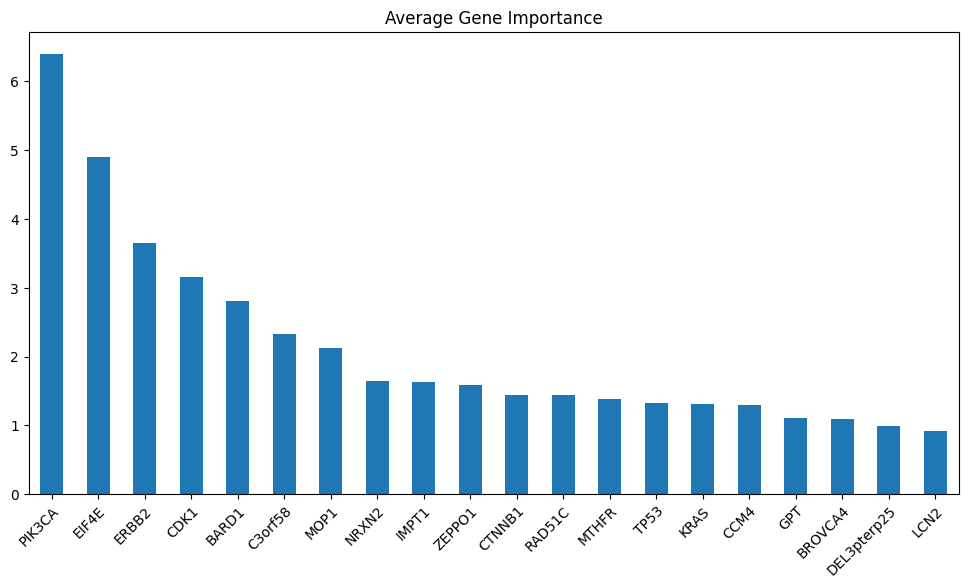

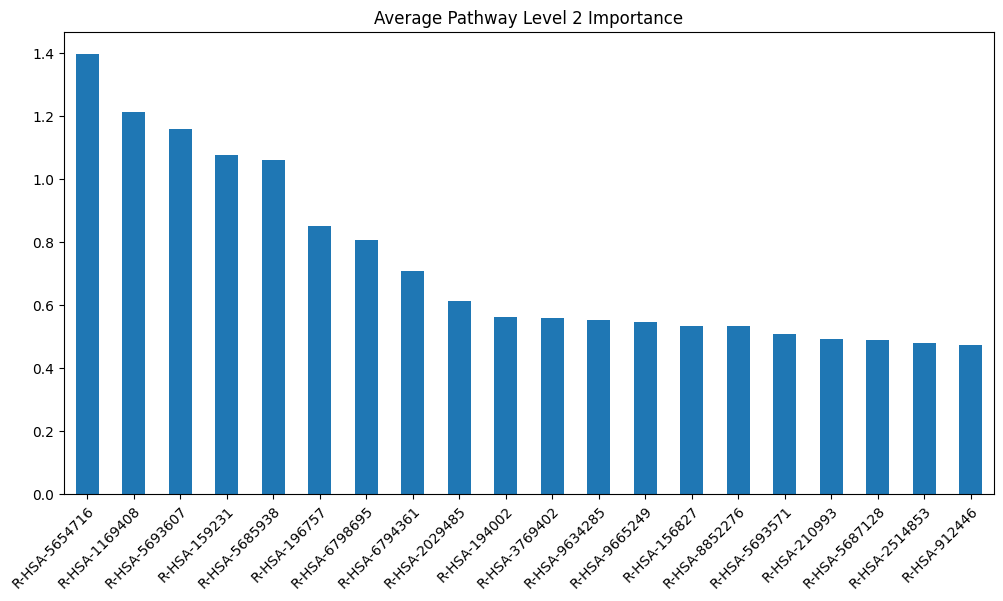

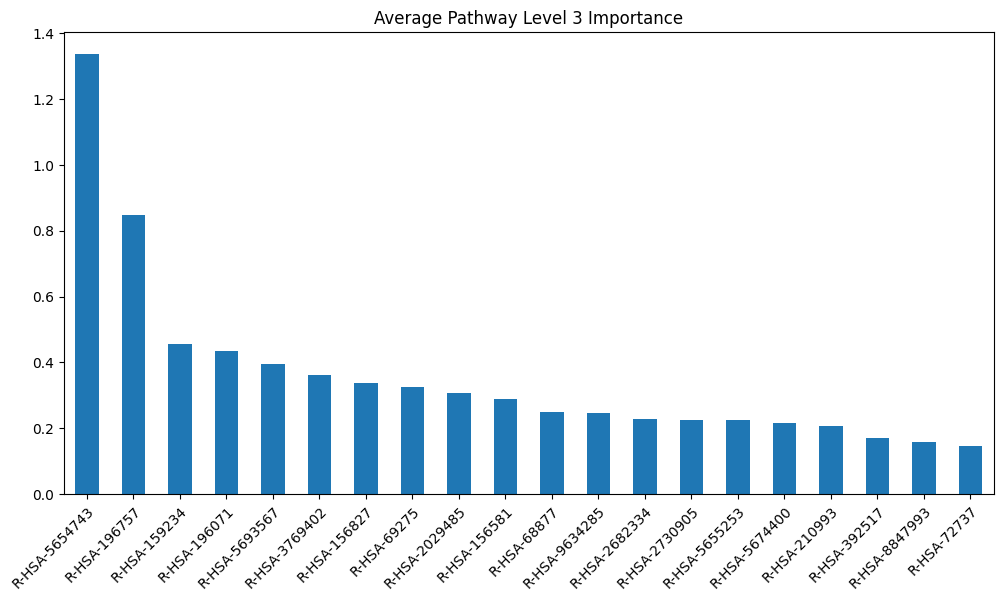

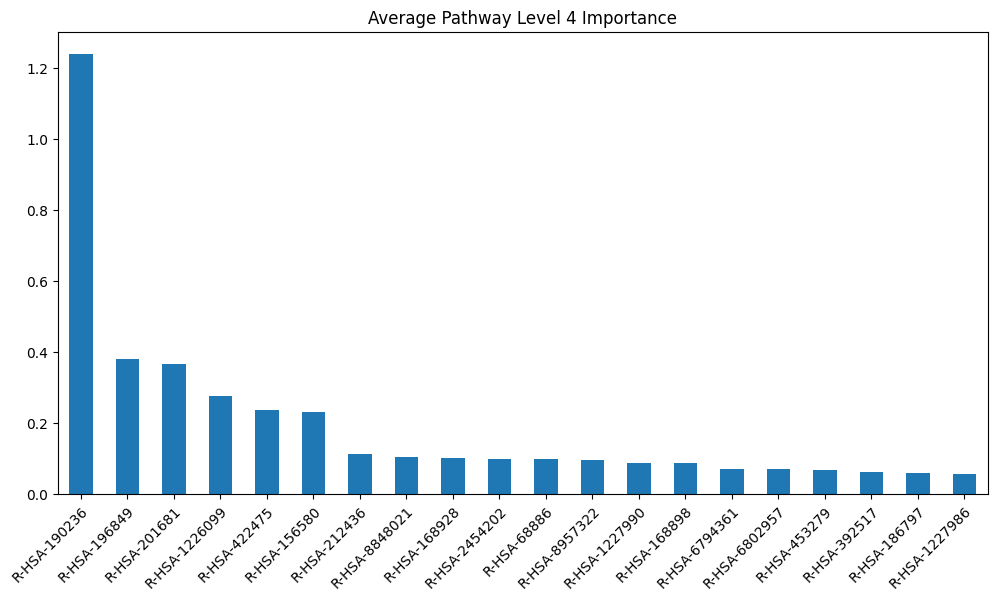

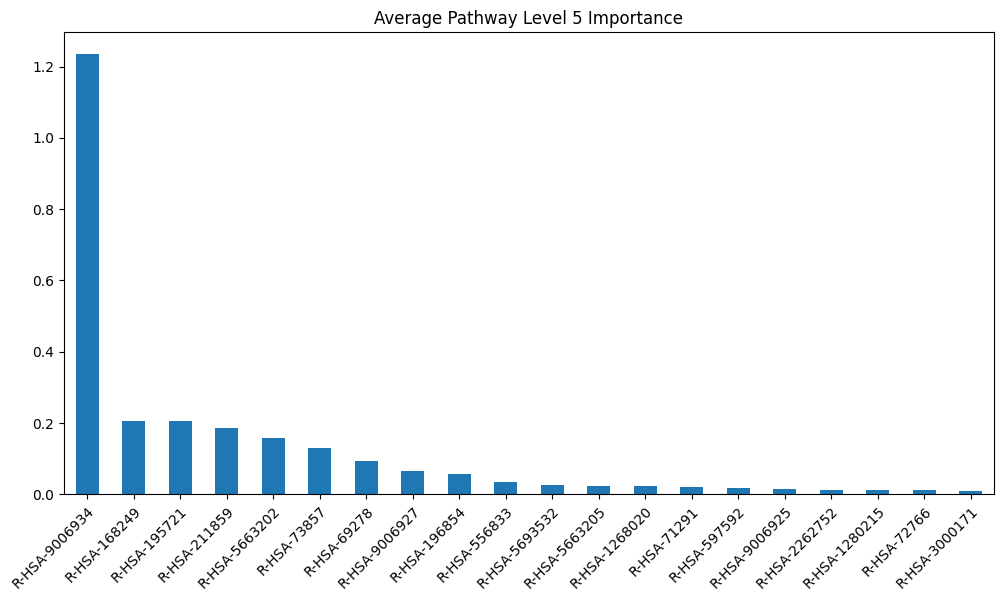

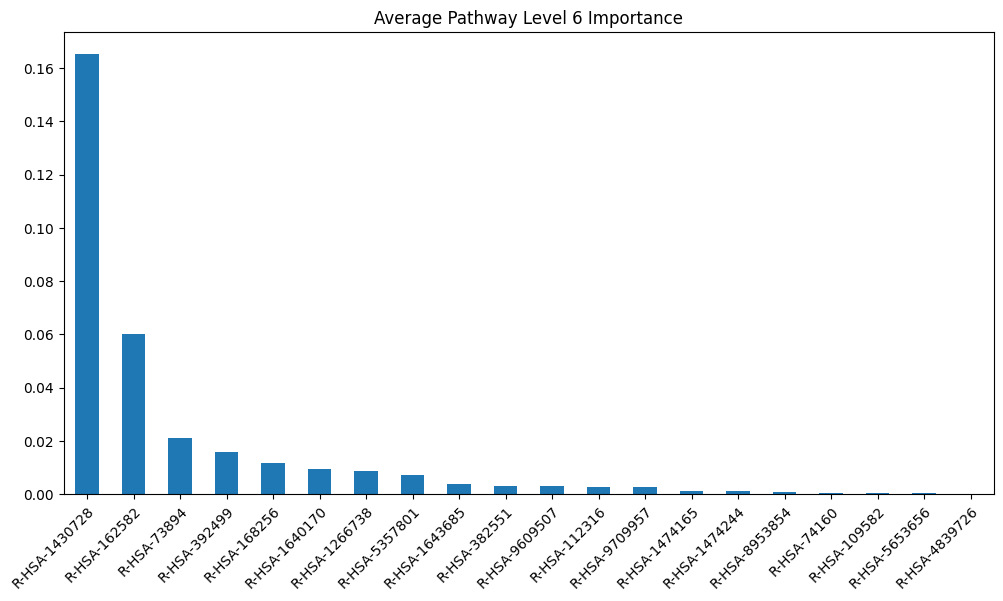

In [18]:
model_layers_importance = {}
model_layers_importance_fig= {}
for i, layer in enumerate(model_scores):
    if i == 0 :
        fig = plt.figure(figsize=(12,6))
        model_scores[layer]['mad'].mean(axis=0).sort_values(ascending=False)[:20].plot(kind='bar')
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
        plt.title('Input Feature Importance')
        plt.show()
        model_layers_importance_fig['Feature Importance'] = fig
    else : 
        layer_title = f"Pathway Level {i} Importance" if i > 1 else "Gene Importance"
        model_layers_importance[layer_title] = layer
        model_layers_importance_fig[layer_title] = visualize_importances(
            model_scores[layer]['sva'].mean(axis=0), title=f"Average {layer_title}")

In [ ]:
importances = model_importances['Gene Importance']
importances = (importances - importances.mean().mean())/importances.mean().std()
importances = importances.abs().mean(axis=0)
gse = importances.sort_values(ascending=False).reset_index()
gse.columns = ['ids' , 'score']
gse.to_csv('C:/Users/Barry/Downloads/gene_enrichment.rnk' , sep='\t' , header=True , index = False)

In [19]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

Total = 11.5Gb 	 Reserved = 0.7Gb 	 Allocated = 0.3Gb
Total = 11.5Gb 	 Reserved = 0.7Gb 	 Allocated = 0.3Gb


In [20]:
# test the model
print("Testing...")
acc = layerwise_infer(
    device, g, np.arange(len(g.nodes())), best_model, batch_size=4096
)
print("Test Accuracy {:.4f}".format(acc.item()))

Testing...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.19it/s]

Test Accuracy 0.9015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.21it/s]


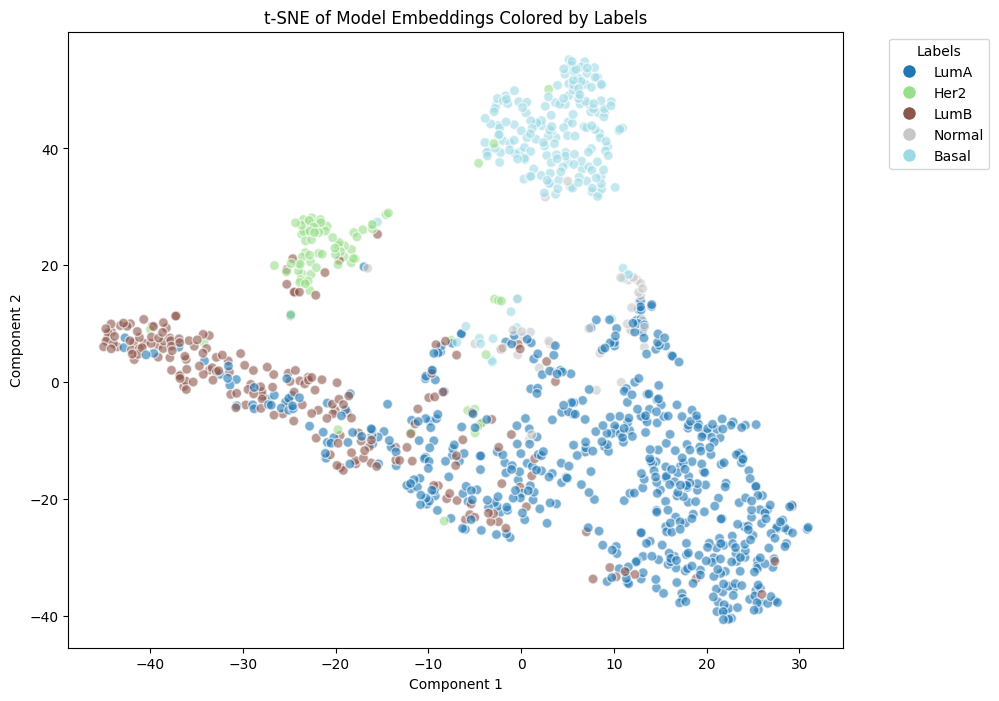

In [21]:
best_model.eval()
with torch.no_grad():
    emb = best_model.embedding_extraction(
        g, g.ndata['feat'] ,device, 4096
    )  # pred in buffer_device

tsne_embedding_plot(emb.detach().cpu().numpy() , meta)